# High Performance Linpack

Results from running the [Intel](https://software.intel.com/content/www/us/en/develop/documentation/mkl-windows-developer-guide/top/intel-math-kernel-library-benchmarks/intel-distribution-for-linpack-benchmark/overview-of-the-intel-distribution-for-linpack-benchmark.html) version of the High Performance Linpack benchmarks. See the README in this directory for more info.

In [1]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML

import pandas as pd
import os, sys
from pprint import pprint
sys.path.extend(('../../reframe', '../../')) # the `modules` package imports `reframe` so need that in sys.modules
import modules

# Performance vs number of nodes
Each benchmark is run on both a single node and all nodes.

The table shows the Gflops/s achieved in the most-recent run on each system/partition/environment combination, plus the ratio between RoCE / IB results.

In [19]:
df = modules.utils.tabulate_last_perf('IntelHpl*', 'testname', 'Gflops') # don't use num_nodes as get NaNs
df.rename(index=lambda t: t.split('_')[-1], inplace=True)  # IntelHpl_all -> all
df.index.name = 'nodes'
modules.plots.add_roce_ib_factor(df)
df = df.transpose() # so now cols are all, single
df['all/single'] = (df['all'] / df['single']).round(1)
display(df)#.style.set_precision(0))

nodes,all,single,all/single
case,,,
alaska:ib-gcc9-impi-verbs,16090.90,1016.54,15.8
alaska:roce-gcc9-impi-verbs,NaN,1036.75,NaN
csd3:cclake-ib-icc19-impi19-ucx,36358.80,2510.37,14.5
csd3:cclake-roce-icc19-impi19-ucx,31557.20,2552.05,12.4
alaska:[roce/ib]-gcc9-impi-verbs,NaN,1.02,NaN
csd3:cclake-[roce/ib]-icc19-impi19-ucx,0.87,1.02,0.9


# Performance History

The plot below shows the Gflop/s history with a series for each system/partition/environment combination. Where performance logs include a git reference (as a tag `"git=<ref>"`) this is used to annotate the data point.

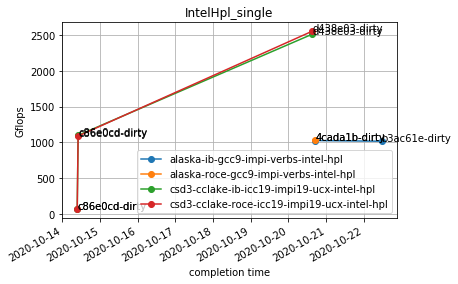

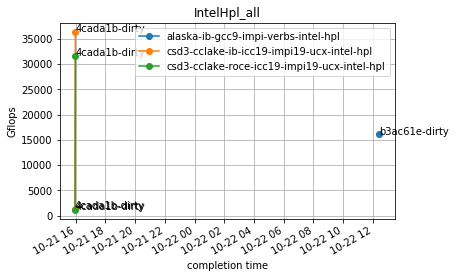

In [4]:
for test in ['IntelHpl_single', 'IntelHpl_all']:
    perf_records = modules.utils.load_perf_logs('../../perflogs', test, '.log')
    if perf_records is None:
        print('%s: no performance logs found' % test)
        continue
    fig, ax = plt.subplots(nrows=1, ncols=1)
    for spe, data in perf_records.groupby(['sysname', 'partition', 'environ']):
        # filter to only Gflops records (might have others)
        data = data.loc[data['perf_var'] == 'Gflops']
        data.plot(ax=ax, x='completion_time', y='perf_value', style=['o-'], label='-'.join(spe))
        
        # annotate points with git_ref:
        for x, y, ref in zip(data['completion_time'], data['perf_value'], data['git']):
            if not pd.isnull(ref):
                ax.annotate(ref, (x, y))
    ax.set_title(test)
    ax.set_xlabel('completion time')
    ax.set_ylabel('Gflops')
    ax.legend()
    ax.grid()    